In [1]:
import pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, VotingClassifier)
from IPython.display import Image

### import data

In [2]:
data = pd.read_csv('../../Data/WeatherOutagesAllJerry.csv')

In [3]:
# clean up data
data = data.dropna(how = 'all')
data = data.fillna(0)
data = data.round(4)

In [4]:
# # of outages apart from equipment outage
natural = data['natural'] = data.Trees + data.Animals + data.Lightning
pd.set_option('display.max_columns', 500)
data.head(5)

,Date,Total_outages,Equipment,Trees,Animals,Lightning,Day_length_hr,Max_temp_F,Avg_Temp_F,Min_temp_F,Max_humidity_percent,Avg_humidity_percent,Min_humidity_percent,Max_visibility_mi,Avg_visibility_mi,Min_visibility_mi,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,Events,Event_fog,Event_rain,Event_snow,Event_thunderstorm,Event_Hail,Event_Tornado,natural
0,9/11/00,0.0,0.0,0.0,0.0,0.0,12.7833,66.0,58.0,50.0,100.0,89.0,58.0,10.0,6.0,0.0,8.0,2.0,9.0,0.01,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9/12/00,2.0,1.0,0.0,1.0,0.0,12.7167,75.0,62.0,52.0,100.0,69.0,33.0,10.0,10.0,7.0,8.0,4.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9/13/00,1.0,1.0,0.0,0.0,0.0,12.6667,77.0,64.0,54.0,97.0,74.0,52.0,10.0,10.0,10.0,16.0,7.0,25.0,0.00,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9/14/00,0.0,0.0,0.0,0.0,0.0,12.6167,84.0,71.0,60.0,87.0,66.0,39.0,10.0,10.0,10.0,17.0,12.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9/15/00,1.0,1.0,0.0,0.0,0.0,12.5500,73.0,66.0,59.0,97.0,79.0,53.0,10.0,10.0,10.0,12.0,5.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data['Total_outages'].max()

49.0

In [6]:
data['natural'].max()

47.0

In [7]:
data['Equipment'].max()

9.0

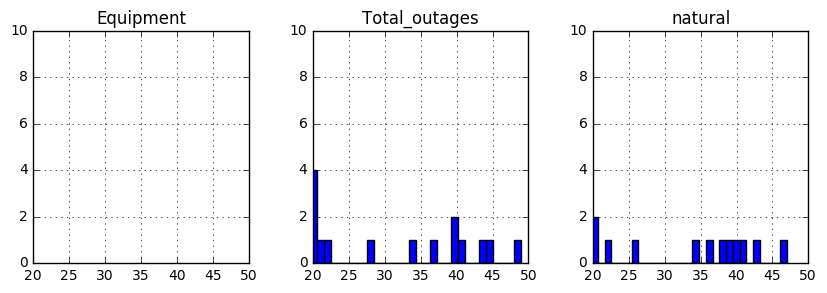

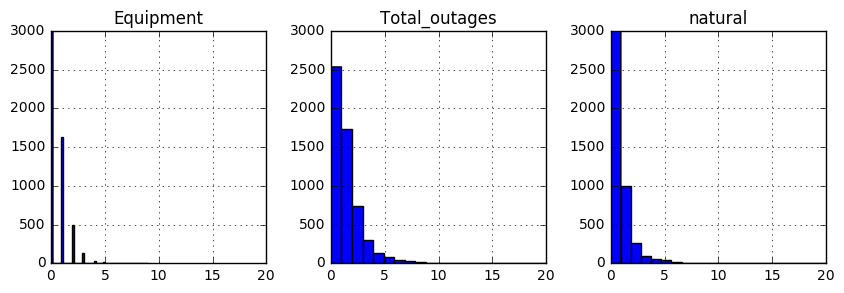

In [8]:
# look at the distribution of power outages

for array in data[['Total_outages','natural','Equipment']].hist(figsize=(10,3),layout=(1,3),bins=50):
    for subplot in array:
        subplot.set_xlim((20,50))
        subplot.set_ylim((0,10))
        
for array in data[['Total_outages','natural','Equipment']].hist(figsize=(10,3),layout=(1,3),bins=50):
    for subplot in array:
        subplot.set_xlim((0,20))
        subplot.set_ylim((0,3000))
        
#0-2, 3-8, >9

{'boxes': [<matplotlib.lines.Line2D at 0x11359bcf8>],
 'caps': [<matplotlib.lines.Line2D at 0x1135a9748>,
 'fliers': [<matplotlib.lines.Line2D at 0x1135aefd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1135ae128>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11359bf28>,
  <matplotlib.lines.Line2D at 0x1135a3ef0>]}

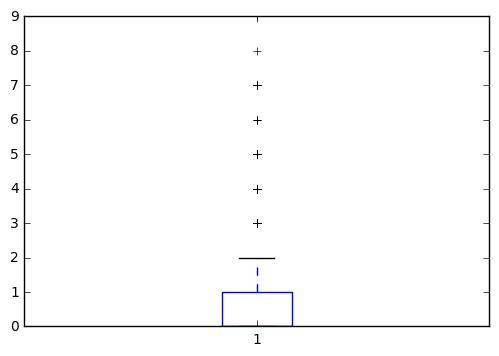

In [11]:
plt.boxplot(data.Equipment)

In [13]:
#data[['Max_temp_F','Avg_Temp_F','Min_temp_F']].plot()
#data[['Max_humidity_percent','Avg_humidity_percent','Min_humidity_percent']].plot()
#data[['Max_visibility_mi']].plot()
#data[['Avg_visibility_mi']].plot()

In [14]:
# convert to classification problem
def f(row):
    """function that categories days with more than 8 outages as extreme, 
                                3-8 outages as bad, and 0-2 as normal"""
    if row['Total_outages'] > 8:
        val = 'extreme'
    elif row['Total_outages'] > 2:
        val = 'bad'
    else:
        val = 'normal'
    return val

data['category'] = data.apply(f, axis=1)

In [15]:
data.head(2)

,Date,Total_outages,Equipment,Trees,Animals,Lightning,Day_length_hr,Max_temp_F,Avg_Temp_F,Min_temp_F,Max_humidity_percent,Avg_humidity_percent,Min_humidity_percent,Max_visibility_mi,Avg_visibility_mi,Min_visibility_mi,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,Events,Event_fog,Event_rain,Event_snow,Event_thunderstorm,Event_Hail,Event_Tornado,natural,category
0,9/11/00,0.0,0.0,0.0,0.0,0.0,12.7833,66.0,58.0,50.0,100.0,89.0,58.0,10.0,6.0,0.0,8.0,2.0,9.0,0.01,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,9/12/00,2.0,1.0,0.0,1.0,0.0,12.7167,75.0,62.0,52.0,100.0,69.0,33.0,10.0,10.0,7.0,8.0,4.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,normal


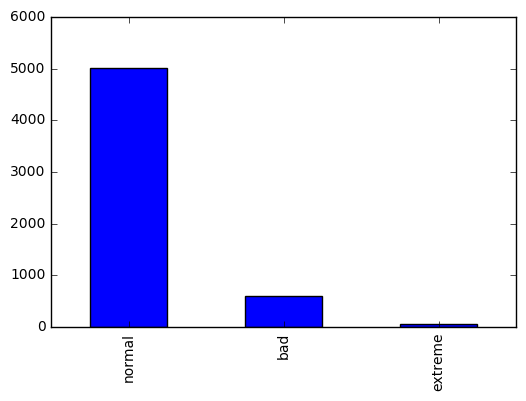

In [16]:
data.category.value_counts().plot(kind='bar')

In [17]:
train,test=train_test_split(data,test_size=0.1,random_state=567)

In [18]:
x_train = train[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Avg_windspeed_mph',
             'Max_windspeed_mph','Max_windgust_mph','Precipitation_in','Event_thunderstorm']]
y_train = pd.factorize(train.category)[0]

x_test = test[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Avg_windspeed_mph',
             'Max_windspeed_mph','Max_windgust_mph','Precipitation_in','Event_thunderstorm']]
y_test = pd.factorize(test.category)[0]

In [19]:
x_train.head(2)

,Day_length_hr,Avg_Temp_F,Avg_humidity_percent,Avg_windspeed_mph,Max_windspeed_mph,Max_windgust_mph,Precipitation_in,Event_thunderstorm
3851,12.6667,46.0,93.0,9.0,20.0,31.0,0.12,0.0
2964,10.4167,49.0,70.0,6.0,16.0,12.0,0.11,0.0


In [20]:
# data normalization
x_train_nor = pd.DataFrame(preprocessing.normalize(x_train[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_train_nor = x_train_nor.fillna(0)
x_test_nor = pd.DataFrame(preprocessing.normalize(x_test[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_test_nor = x_test_nor.fillna(0)

In [21]:
# data standardization
x_train_std = pd.DataFrame(preprocessing.scale(x_train[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_train_std = x_train_std.fillna(0)
x_test_std = pd.DataFrame(preprocessing.scale(x_test[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_test_std = x_test_std.fillna(0)

In [22]:
x_train_std.head(2)

,0,1,2,3,4,5
0,0.197493,-0.636699,1.558271,0.803299,1.309560,0.040439
1,-0.672493,-0.348591,-0.318426,0.097365,-0.760053,0.001387


In [23]:
x_train_nor.head(2)

,0,1,2,3,4,5
0,0.114275,0.414997,0.839015,0.180433,0.279672,0.001083
1,0.117874,0.554477,0.792111,0.181054,0.135790,0.001245


In [24]:
x_train_nor.size

30582

In [25]:
y_test.size

567

### Decision Tree 

In [37]:
# using balanced class weight will give higher error, but can predict extreme cases better
dt = DecisionTreeClassifier(min_samples_leaf=5,max_depth=3,class_weight='balanced')#class_weight={0:0.05,1:0.05,2:0.9}

clf_nor = dt.fit(x_train_nor,y_train)

y_train_pred_nor = dt.predict(x_train_nor)
y_test_pred_nor = dt.predict(x_test_nor)

print("Train error for normalized data",mean_squared_error(y_train,y_train_pred_nor))
print("Test error for normalized data",mean_squared_error(y_test,y_test_pred_nor))
print("training score for normalized data",dt.score(x_train_nor,y_train))

tree_dot_nor = export_graphviz(clf_nor,out_file = 'tree_all_nor.dot')

Train error for normalized data 0.33058661958
Test error for normalized data 0.384479717813
training score for normalized data 0.735923092015


In [38]:
clf_std = dt.fit(x_train_std,y_train)

y_train_pred_std = dt.predict(x_train_std)
y_test_pred_std = dt.predict(x_test_std)

print("Train error for standardized data",mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data",mean_squared_error(y_test,y_test_pred_std))
print("training score for standardized data",dt.score(x_train_std,y_train))

tree_dot_std = export_graphviz(clf_std,out_file = 'tree_all_std.dot')

Train error for standardized data 1.23778693349
Test error for standardized data 1.1975308642
training score for standardized data 0.490876986463


In [39]:
# probability of each event
print(dt.predict_proba(x_train_std)[0:20], y_test[0:20])

[[ 0.34236268  0.28266867  0.37496865]
 [ 0.34236268  0.28266867  0.37496865]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.09345275  0.26968405  0.6368632 ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.32731792  0.6145484   0.05813368]
 [ 0.34236268  0.28266867  0.37496865]
 [ 0.09345275  0.26968405  0.6368632 ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.34236268  0.28266867  0.37496865]
 [ 0.34236268  0.28266867  0.37496865]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.73591258  0.26408742  0.        ]
 [ 0.34236268  0.28266867  0.37496865]
 [ 0.32731792  0.6145484   0.05813368]] [0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 2]


In [40]:
# View a list of the features and their importance scores
list(zip(x_train_std, dt.feature_importances_))

[(0, 0.16361543750124091),
 (1, 0.057151722224218077),
 (2, 0.0),
 (3, 0.60809539636970733),
 (4, 0.0),
 (5, 0.1711374439048336)]

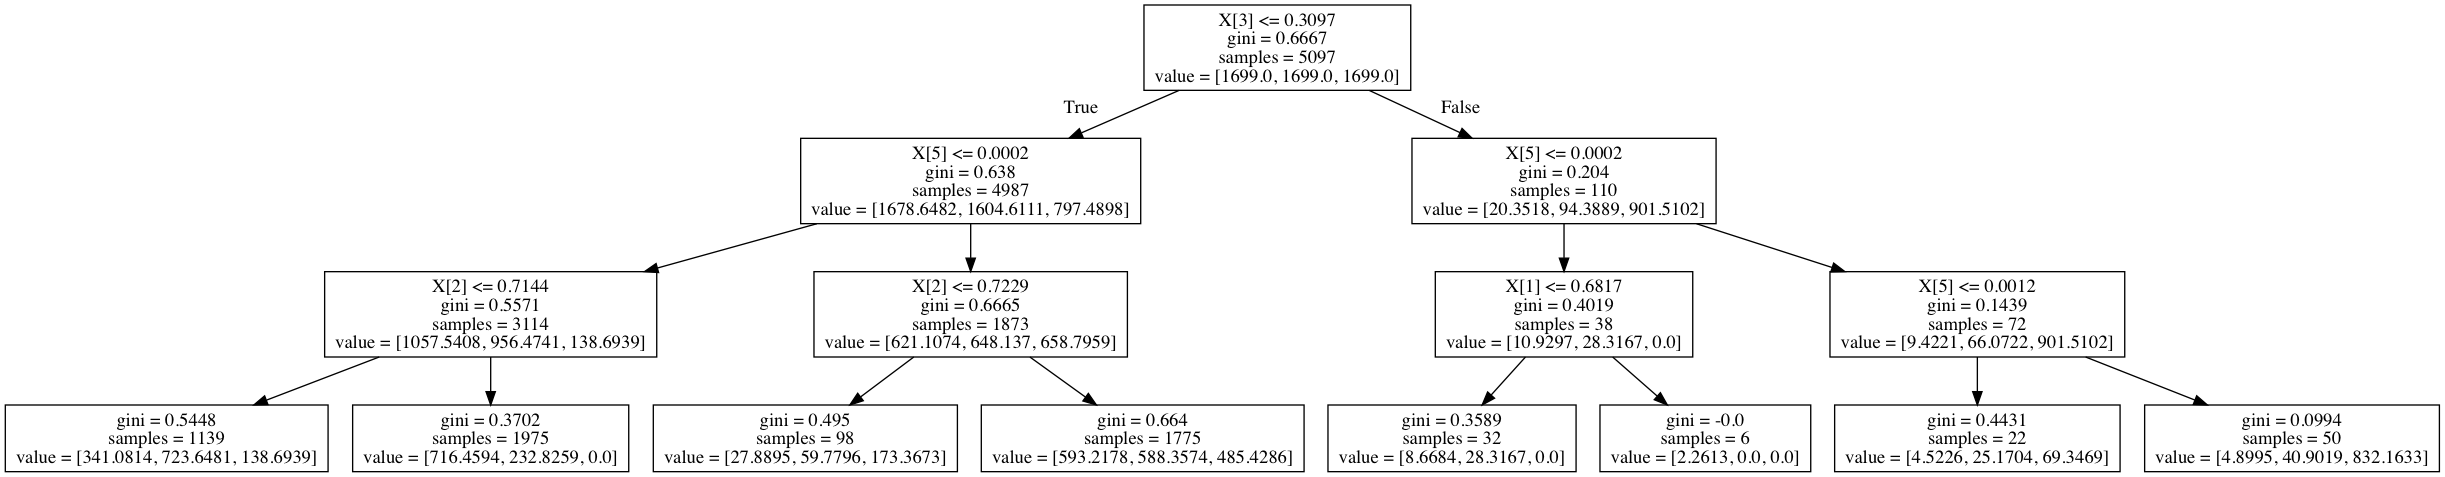

In [41]:
graph = pydotplus.graphviz.graph_from_dot_file('tree_all_nor.dot')
Image(graph.create_png())

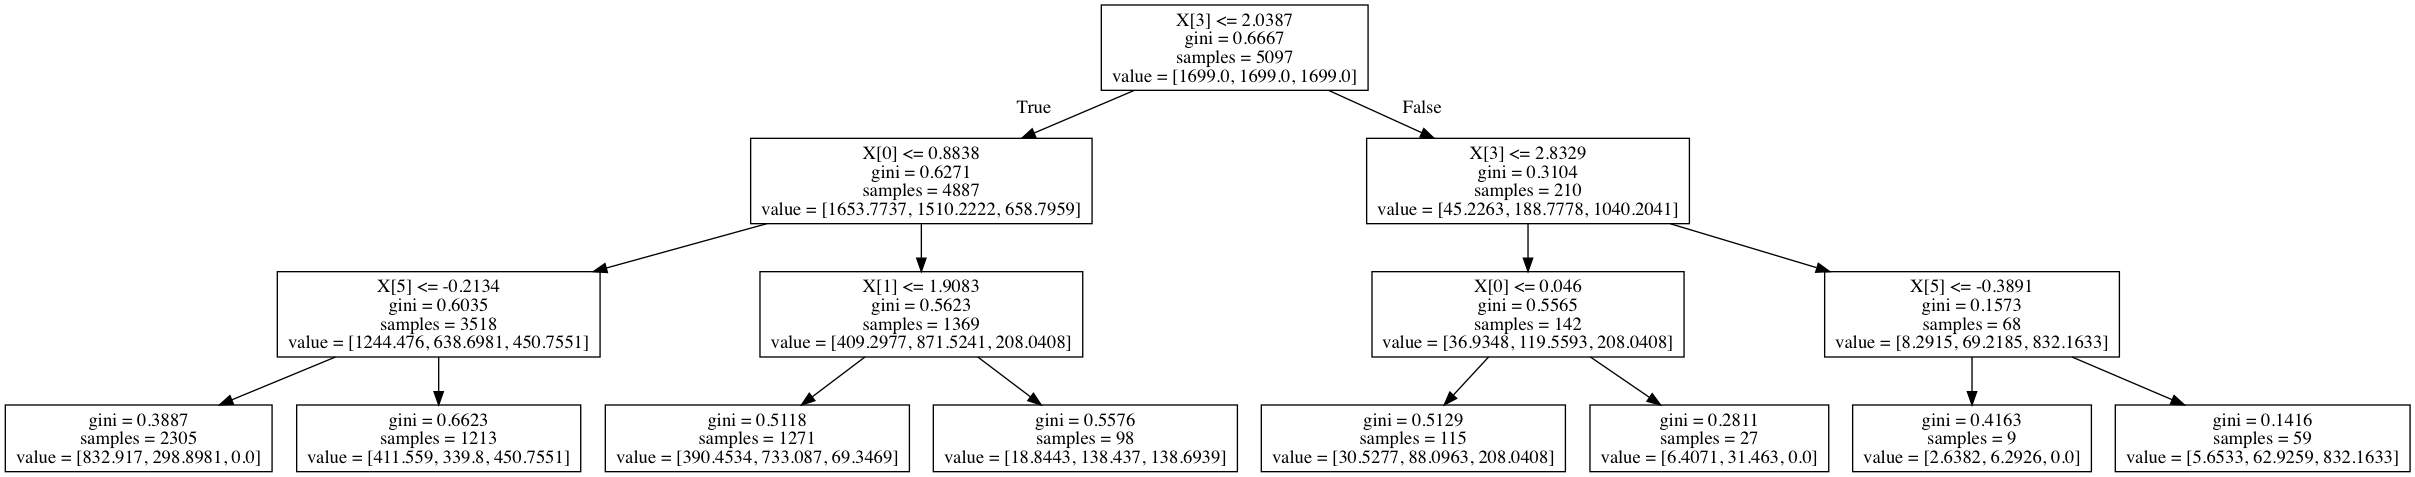

In [42]:
graph = pydotplus.graphviz.graph_from_dot_file('tree_all_std.dot')
Image(graph.create_png())

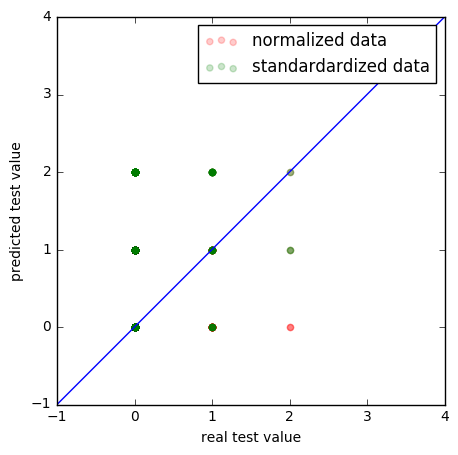

In [43]:
# plot the results
plt.figure(figsize=(5,5))
plt.scatter(y_test,y_test_pred_nor,alpha=0.2,color='red',label='normalized data')
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='green',label='standardardized data')
plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,4])
plt.ylim([-1,4])
plt.legend()

training score using [0, 3] features is 0.710026
training score using [0, 5] features is 0.420640
training score using [3, 5] features is 0.665293


/Users/Yanbo/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


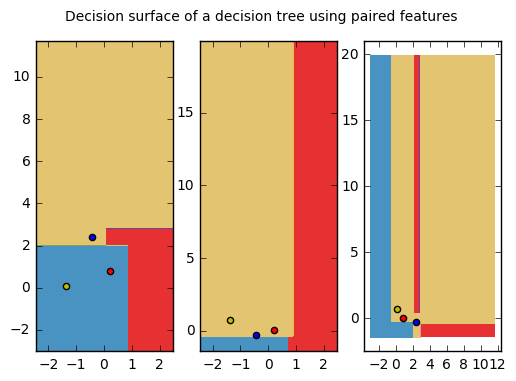

In [135]:
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration
n_classes = 3

for pairidx, pair in enumerate([[0, 3], [0, 5], [3, 5]]):
# We only take the two corresponding features
    X = x_train_std.iloc[:,pair]
    y = y_train

    # Train
    clf = DecisionTreeClassifier(min_samples_leaf=5,max_depth=3,class_weight='balanced').fit(X, y)
    print("training score using %s features is %f" % (pair, clf.score(X,y)))
    # Plot the decision boundary
    plt.subplot(1, 3, pairidx+1)
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    #plt.xlabel(iris.feature_names[pair[0]])
    #plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X.iloc[idx[0][0].tolist(), 0], X.iloc[idx[0][0].tolist(), 1], c=color,
                    cmap=plt.cm.Paired)

plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

### Advanced Tree Methods

In [145]:
n_estimators = 30 # number of trees used, default=10 for rf, et, 50 for ab, 100 for gb
#n_jobs=-1, the number of jobs is set to the number of cores

dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=5, 
                            class_weight='balanced', presort=True)
rf = RandomForestClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1,
                            class_weight='balanced')
et = ExtraTreesClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1,
                          class_weight='balanced')
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),learning_rate=0.1)
bg = BaggingClassifier(max_samples=3,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5)

Train error for standardized data using DecisionTree is 1.23778693349
Test error for standardized data using DecisionTree is 1.1975308642
Feature importance using DecisionTree is 
 [(0, 0.16361543750123667), (1, 0.057151722224213511), (2, 0.0), (3, 0.60809539636970145), (4, 0.0), (5, 0.17113744390484831)] 

Train error for standardized data using RandomForest is 0.0684716499902
Test error for standardized data using RandomForest is 0.1569664903
Feature importance using RandomForest is 
 [(0, 0.17495876111253847), (1, 0.16498553183012968), (2, 0.12511682050499384), (3, 0.25801137489793607), (4, 0.090626933470311213), (5, 0.18630057818409076)] 

Train error for standardized data using ExtraTrees is 0.183245046106
Test error for standardized data using ExtraTrees is 0.3139329806
Feature importance using ExtraTrees is 
 [(0, 0.15461118770140128), (1, 0.12058398679275596), (2, 0.12853124987943962), (3, 0.24952427540809072), (4, 0.092718766654453305), (5, 0.15403053356385923)] 

Train error 

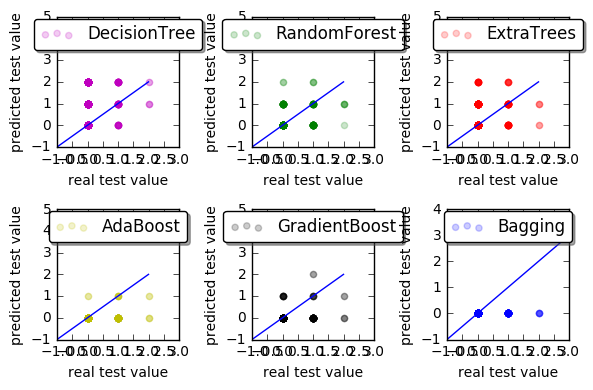

In [146]:
plot_idx = 1
for method, color_, label_ in [(dt,'m','DecisionTree'),(rf,'g','RandomForest'), (et,'r','ExtraTrees'),
                               (ab,'y','AdaBoost'),(gb,'k','GradientBoost')]:
    clf_std = method.fit(x_train_std,y_train)

    y_train_pred_std = method.predict(x_train_std)
    y_test_pred_std = method.predict(x_test_std)

    print("Train error for standardized data using %s is" % (label_),mean_squared_error(y_train,y_train_pred_std))
    print("Test error for standardized data using %s is" % (label_),mean_squared_error(y_test,y_test_pred_std))
    print("Feature importance using %s is" % (label_),'\n',list(zip(x_train_std, method.feature_importances_)),'\n')
    plt.subplot(2, 3, plot_idx)
    plt.scatter(y_test,y_test_pred_std,alpha=0.2,color=color_,label=label_)
    plt.plot(np.arange(-1,3),np.arange(-1,3))
    plt.xlabel('real test value')
    plt.ylabel('predicted test value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlim([-1,3])
    plt.ylim([-1,5])
    plt.tight_layout()
    plot_idx += 1
    
clf_std = bg.fit(x_train_std,y_train)
y_train_pred_std = bg.predict(x_train_std)
y_test_pred_std = bg.predict(x_test_std)
print("Train error for standardized data using %s is" % 'Bagging',mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data using %s is" % 'Bagging',mean_squared_error(y_test,y_test_pred_std))

plt.subplot(2, 3, 6)
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='b',label='Bagging')    

plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,3])
plt.ylim([-1,4])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()

### without weights on class

Train error for standardized data using DecisionTree is 0.135766136943
Test error for standardized data using DecisionTree is 0.146384479718
Feature importance using DecisionTree is 
 [(0, 0.33231831635233416), (1, 0.19782641645221291), (2, 0.0), (3, 0.40321735881445014), (4, 0.066637908381002808), (5, 0.0)] 

Train error for standardized data using RandomForest is 0.0996664704728
Test error for standardized data using RandomForest is 0.134038800705
Feature importance using RandomForest is 
 [(0, 0.23918332942345477), (1, 0.19614352728718357), (2, 0.12272427362485513), (3, 0.19904327712406042), (4, 0.12682632499242275), (5, 0.11607926754802343)] 

Train error for standardized data using ExtraTrees is 0.144398665882
Test error for standardized data using ExtraTrees is 0.139329805996
Feature importance using ExtraTrees is 
 [(0, 0.19526022547058153), (1, 0.19001111713748436), (2, 0.10134166751989368), (3, 0.26387813585700626), (4, 0.081466608049257871), (5, 0.10137557929910961)] 

Train 

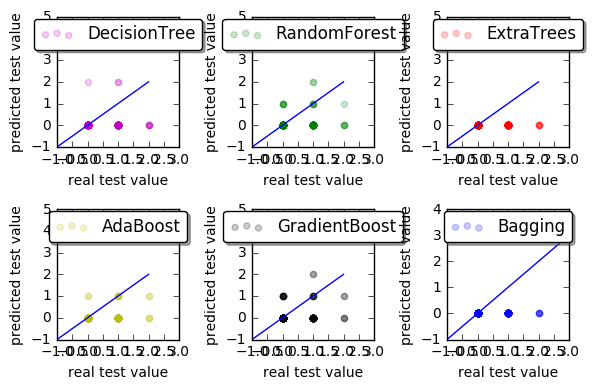

In [144]:
n_estimators = 30 # number of trees used, default=10 for rf, et, 50 for ab, 100 for gb
#n_jobs=-1, the number of jobs is set to the number of cores

dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=5, presort=True)
rf = RandomForestClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1)
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),learning_rate=0.1)
bg = BaggingClassifier(max_samples=3,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5)

plot_idx = 1
for method, color_, label_ in [(dt,'m','DecisionTree'),(rf,'g','RandomForest'), (et,'r','ExtraTrees'),
                               (ab,'y','AdaBoost'),(gb,'k','GradientBoost')]:
    clf_std = method.fit(x_train_std,y_train)

    y_train_pred_std = method.predict(x_train_std)
    y_test_pred_std = method.predict(x_test_std)

    print("Train error for standardized data using %s is" % (label_),mean_squared_error(y_train,y_train_pred_std))
    print("Test error for standardized data using %s is" % (label_),mean_squared_error(y_test,y_test_pred_std))
    print("Feature importance using %s is" % (label_),'\n',list(zip(x_train_std, method.feature_importances_)),'\n')
    plt.subplot(2, 3, plot_idx)
    plt.scatter(y_test,y_test_pred_std,alpha=0.2,color=color_,label=label_)
    plt.plot(np.arange(-1,3),np.arange(-1,3))
    plt.xlabel('real test value')
    plt.ylabel('predicted test value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlim([-1,3])
    plt.ylim([-1,5])
    plt.tight_layout()
    plot_idx += 1
    
clf_std = bg.fit(x_train_std,y_train)
y_train_pred_std = bg.predict(x_train_std)
y_test_pred_std = bg.predict(x_test_std)
print("Train error for standardized data using %s is" % 'Bagging',mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data using %s is" % 'Bagging',mean_squared_error(y_test,y_test_pred_std))

plt.subplot(2, 3, 6)
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='b',label='Bagging')    

plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,3])
plt.ylim([-1,5])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()